In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import ast
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([['contract'], ['fulltime'], ['internship'], ['parttime'], ['temporary']])

MultiLabelBinarizer()

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [7]:
def visualize_graph_insights(graph: nx.Graph, max_nodes: int = 1000):
    """
    Create multiple visualizations to understand the graph structure
    """
    plt.style.use('seaborn-v0_8-poster')
    
    def create_subset_graph(nodes):
        return graph.subgraph(nodes)
    
    # 1. Visualize highest degree nodes
    def plot_high_degree_nodes():
        print("Plotting high-degree nodes subset...")
        degrees = dict(graph.degree())
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        top_node_ids = [node for node, _ in top_nodes]
        
        subgraph = create_subset_graph(top_node_ids)
        pos = nx.spring_layout(subgraph, k=1/np.sqrt(len(subgraph)))
        
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Color nodes by degree
        node_colors = [degrees[node] for node in subgraph.nodes()]
        
        # Create scatter plot for colorbar reference
        scatter = ax.scatter([], [], c=[], cmap=plt.cm.viridis)
        scatter.set_array(np.array(node_colors))
        
        nx.draw_networkx_nodes(subgraph, pos, 
                             node_color=node_colors,
                             node_size=100,
                             cmap=plt.cm.viridis,
                             alpha=0.7,
                             ax=ax)
        nx.draw_networkx_edges(subgraph, pos, alpha=0.1, ax=ax)
        
        plt.colorbar(scatter, label="Node Degree")
        ax.set_title(f"Top {max_nodes} Highest Degree Nodes")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    # 2. Visualize communities
    def plot_communities():
        print("Plotting community detection visualization...")
        # Get a random sample of nodes for community detection
        sample_nodes = np.random.choice(list(graph.nodes()), 
                                      size=min(max_nodes, len(graph)), 
                                      replace=False)
        subgraph = create_subset_graph(sample_nodes)
        
        # Detect communities using Louvain method
        communities = nx.community.louvain_communities(subgraph)
        
        # Create a color map for nodes based on their community
        color_map = {}
        for i, community in enumerate(communities):
            for node in community:
                color_map[node] = i
        
        fig, ax = plt.subplots(figsize=(15, 10))
        pos = nx.spring_layout(subgraph)
        
        # Draw nodes colored by community
        nx.draw_networkx_nodes(subgraph, pos,
                             node_color=[color_map[node] for node in subgraph.nodes()],
                             node_size=100,
                             cmap=plt.cm.tab20,
                             alpha=0.7,
                             ax=ax)
        nx.draw_networkx_edges(subgraph, pos, alpha=0.1, ax=ax)
        
        ax.set_title(f"Community Structure (Sample of {len(subgraph)} nodes)")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"Number of communities detected: {len(communities)}")
    
    # 3. Visualize company clusters
    def plot_company_clusters():
        print("Plotting company clusters...")
        # Get companies with multiple job listings
        company_counts = {}
        for node in graph.nodes():
            company = graph.nodes[node].get('company', '')
            company_counts[company] = company_counts.get(company, 0) + 1
        
        top_companies = sorted(company_counts.items(), 
                             key=lambda x: x[1], 
                             reverse=True)[:10]
        
        # Create subgraph of top companies
        nodes_to_include = []
        for company, _ in top_companies:
            company_nodes = [node for node in graph.nodes() 
                           if graph.nodes[node].get('company') == company]
            nodes_to_include.extend(company_nodes[:50])  # Limit to 50 nodes per company
        
        subgraph = create_subset_graph(nodes_to_include)
        pos = nx.spring_layout(subgraph)
        
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Color nodes by company
        company_colors = plt.cm.tab10(np.linspace(0, 1, len(top_companies)))
        color_map = {}
        for i, (company, _) in enumerate(top_companies):
            color_map[company] = company_colors[i]
        
        nx.draw_networkx_nodes(subgraph, pos,
                             node_color=[color_map[graph.nodes[node]['company']] 
                                       for node in subgraph.nodes()],
                             node_size=100,
                             alpha=0.7,
                             ax=ax)
        nx.draw_networkx_edges(subgraph, pos, alpha=0.1, ax=ax)
        
        # Add legend
        legend_elements = [Patch(facecolor=color_map[company], 
                               label=f"{company} ({count} jobs)")
                         for company, count in top_companies]
        ax.legend(handles=legend_elements, 
                 loc='center left', 
                 bbox_to_anchor=(1, 0.5))
        
        ax.set_title("Top 10 Companies Job Networks")
        ax.axis('off')
        plt.tight_layout()
        plt.show()


    
    # Execute all visualizations
    plot_high_degree_nodes()
    plot_communities()
    plot_company_clusters()
    
# Print some basic graph statistics
def print_graph_stats(graph: nx.Graph):
    print("\nGraph Statistics:")
    print(f"Number of nodes: {graph.number_of_nodes():,}")
    print(f"Number of edges: {graph.number_of_edges():,}")
    print(f"Average degree: {sum(dict(graph.degree()).values()) / graph.number_of_nodes():.2f}")
    print(f"Density: {nx.density(graph):.6f}")
    
    # Get degree distribution
    degrees = [d for n, d in graph.degree()]
    print(f"Min degree: {min(degrees)}")
    print(f"Max degree: {max(degrees)}")
    print(f"Median degree: {np.median(degrees):.1f}")
    
    # Count number of connected components
    components = list(nx.connected_components(graph))
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {len(max(components, key=len)):,} nodes")

In [8]:
final_graph = 'final_complete_graph.pkl'
nodes_only = 'graph_with_nodes.pkl'

print("Loading graph from pickle file...")
with open(nodes_only, 'rb') as f:
    graph = pickle.load(f)

Loading graph from pickle file...


Plotting job type distribution...


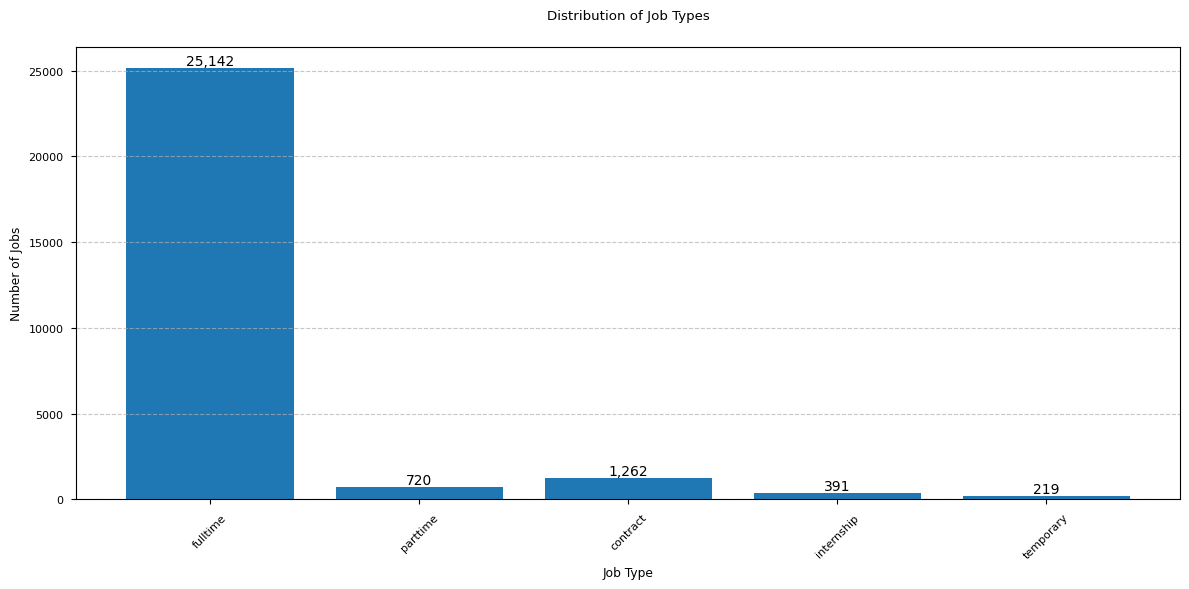


Job Type Distribution:
fulltime: 25,142 jobs (90.7%)
parttime: 720 jobs (2.6%)
contract: 1,262 jobs (4.6%)
internship: 391 jobs (1.4%)
temporary: 219 jobs (0.8%)


In [9]:
    # 4. Visualize job type distribution
    def plot_job_type_distribution(graph: nx.Graph):
        """
        Visualize the distribution of job types in the graph
        """
        print("Plotting job type distribution...")
        job_types = {'fulltime': 0, 'parttime': 0, 'contract': 0, 'internship': 0, 'temporary': 0}

        for node in graph.nodes():
            try:
                types = graph.nodes[node].get('job_type_encoding', [])
                # Handle string representation of list
                if isinstance(types, str):
                    types = ast.literal_eval(types)
                # Handle numpy array
                if isinstance(types, np.ndarray):
                    types = types.tolist()
                # Convert to list if it's not already
                if not isinstance(types, list):
                    types = [types]

                # Decode job types using the MultiLabelBinarizer
                decoded_types = mlb.inverse_transform(np.array(types).reshape(1, -1))[0]
                for job_type in decoded_types:
                    job_types[job_type] += 1

            except Exception as e:
                print(f"Error processing node {node}: {str(e)}")
                continue

        # Create the visualization
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create bar plot
        bars = ax.bar(job_types.keys(), job_types.values())

        # Customize the plot
        ax.set_title("Distribution of Job Types", pad=20)
        ax.set_xlabel("Job Type")
        ax.set_ylabel("Number of Jobs")

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Add grid for better readability
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to prevent label cutoff
        plt.tight_layout()

        # Show the plot
        plt.show()

        # Print the distribution
        print("\nJob Type Distribution:")
        for job_type, count in job_types.items():
            print(f"{job_type}: {count:,} jobs ({count/sum(job_types.values())*100:.1f}%)")
            
plot_job_type_distribution(graph)


Graph Statistics:
Number of nodes: 25,142
Number of edges: 0
Average degree: 0.00
Density: 0.000000
Min degree: 0
Max degree: 0
Median degree: 0.0
Number of connected components: 25142
Largest component size: 1 nodes
Plotting high-degree nodes subset...


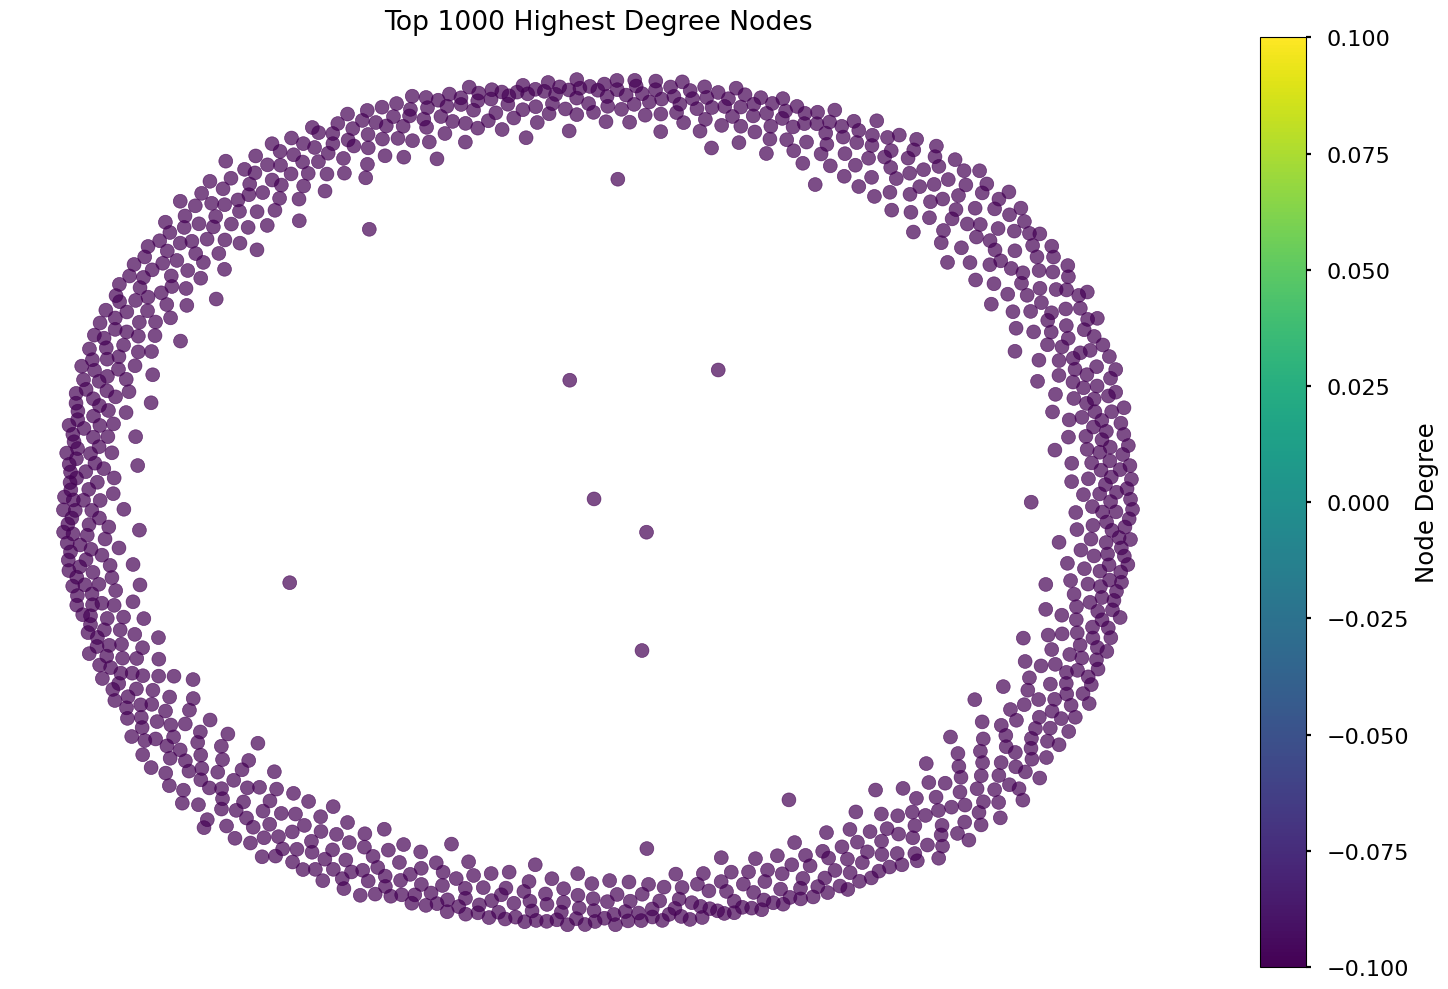

Plotting community detection visualization...


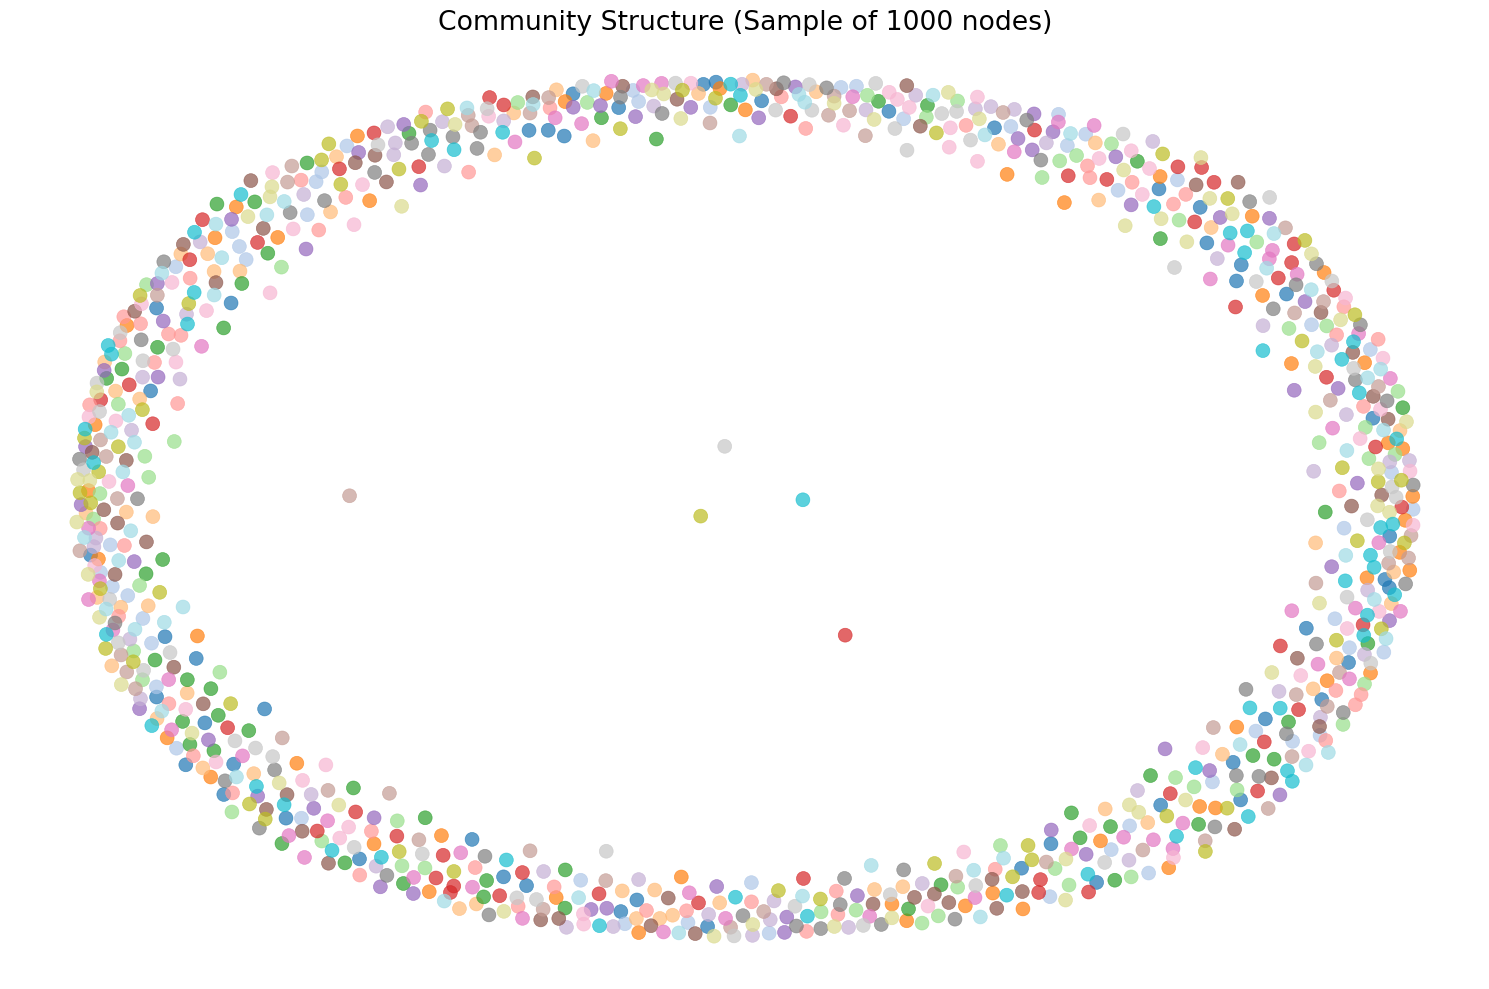

Number of communities detected: 1000
Plotting company clusters...


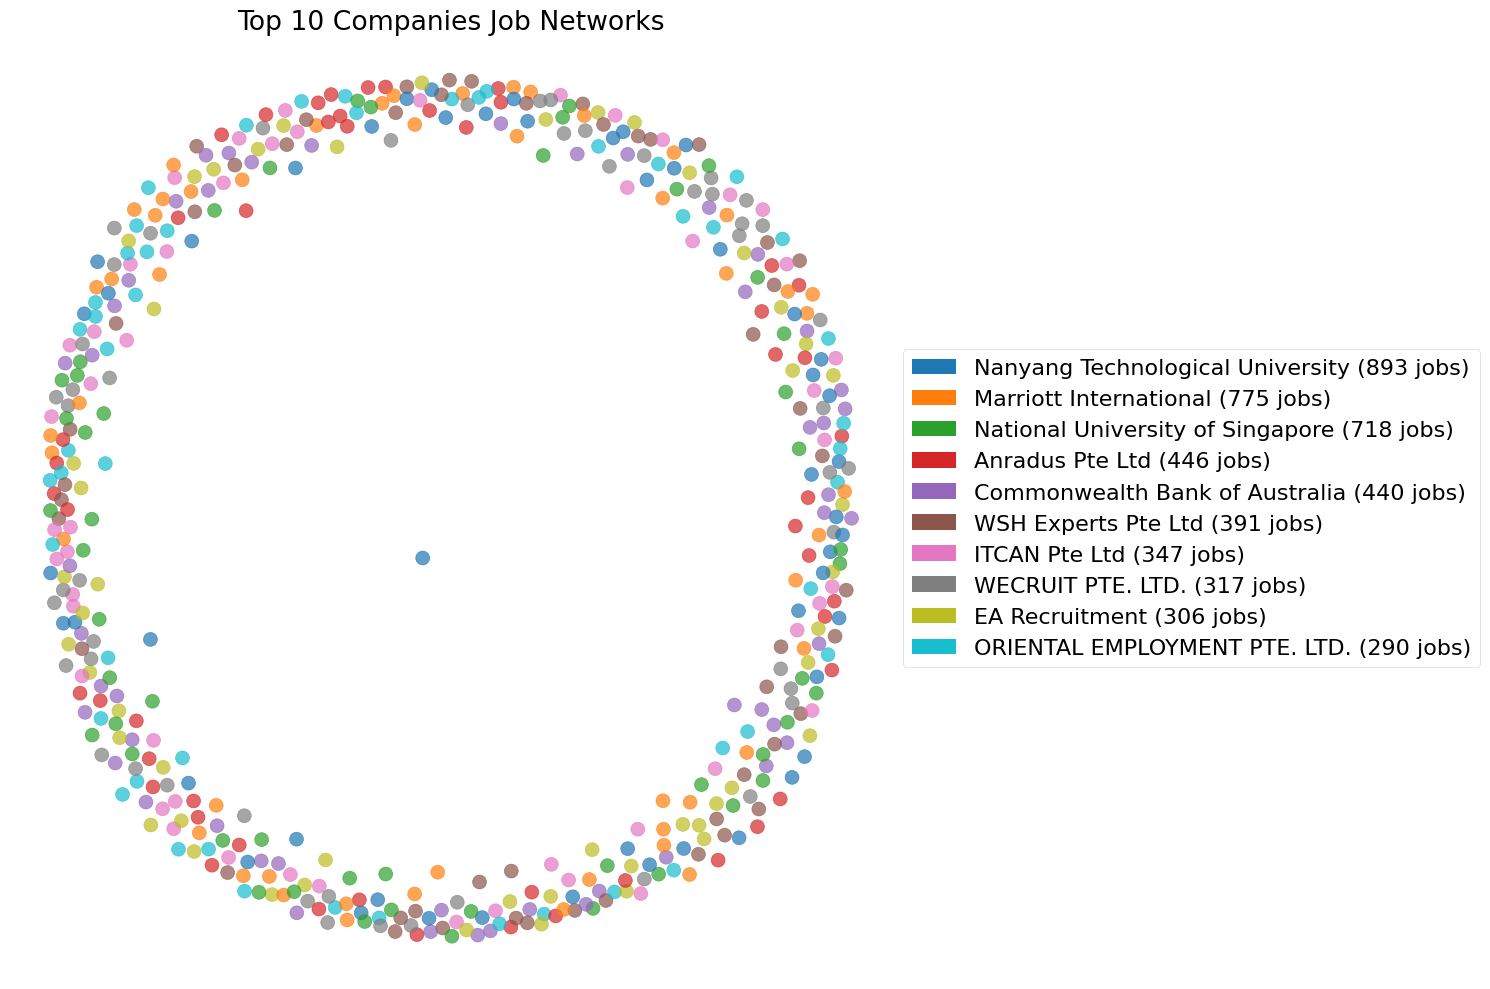

In [10]:
# Get basic statistics
print_graph_stats(graph)

# Generate all visualizations
visualize_graph_insights(graph)

# Or generate specific visualizations
# visualize_graph_insights(graph, max_nodes=500)  # Use fewer nodes for faster visualization

Loading graph from pickle file...

Graph Statistics:
Number of nodes: 25,142
Number of edges: 1,807,738
Average degree: 143.80
Density: 0.005720
Min degree: 0
Max degree: 892
Median degree: 14.0
Number of connected components: 5833
Largest component size: 893 nodes
Plotting high-degree nodes subset...


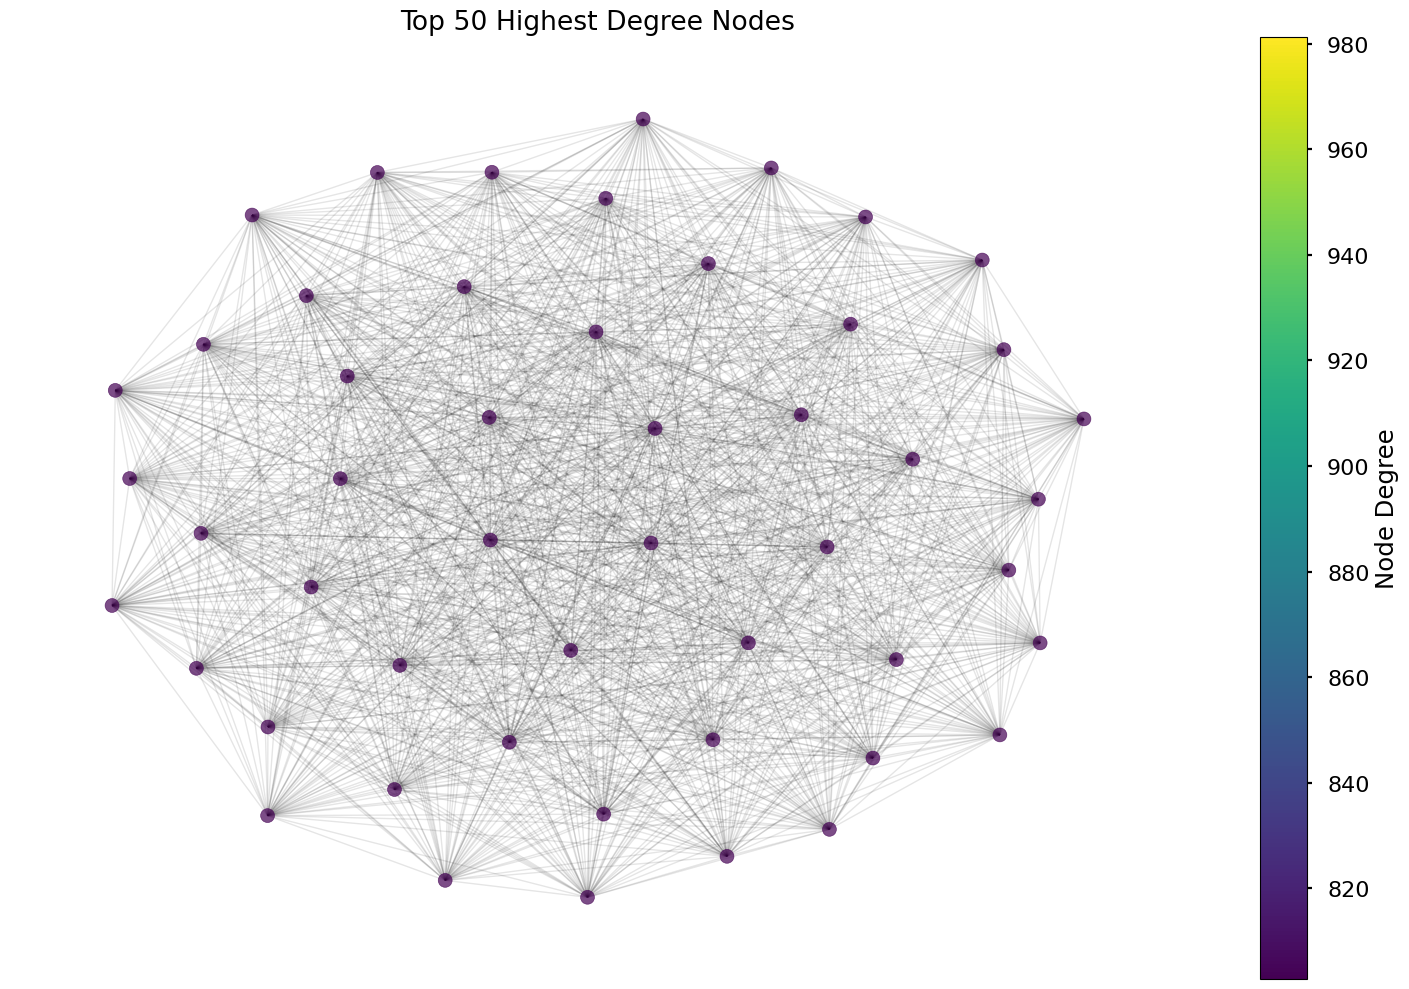

Plotting community detection visualization...


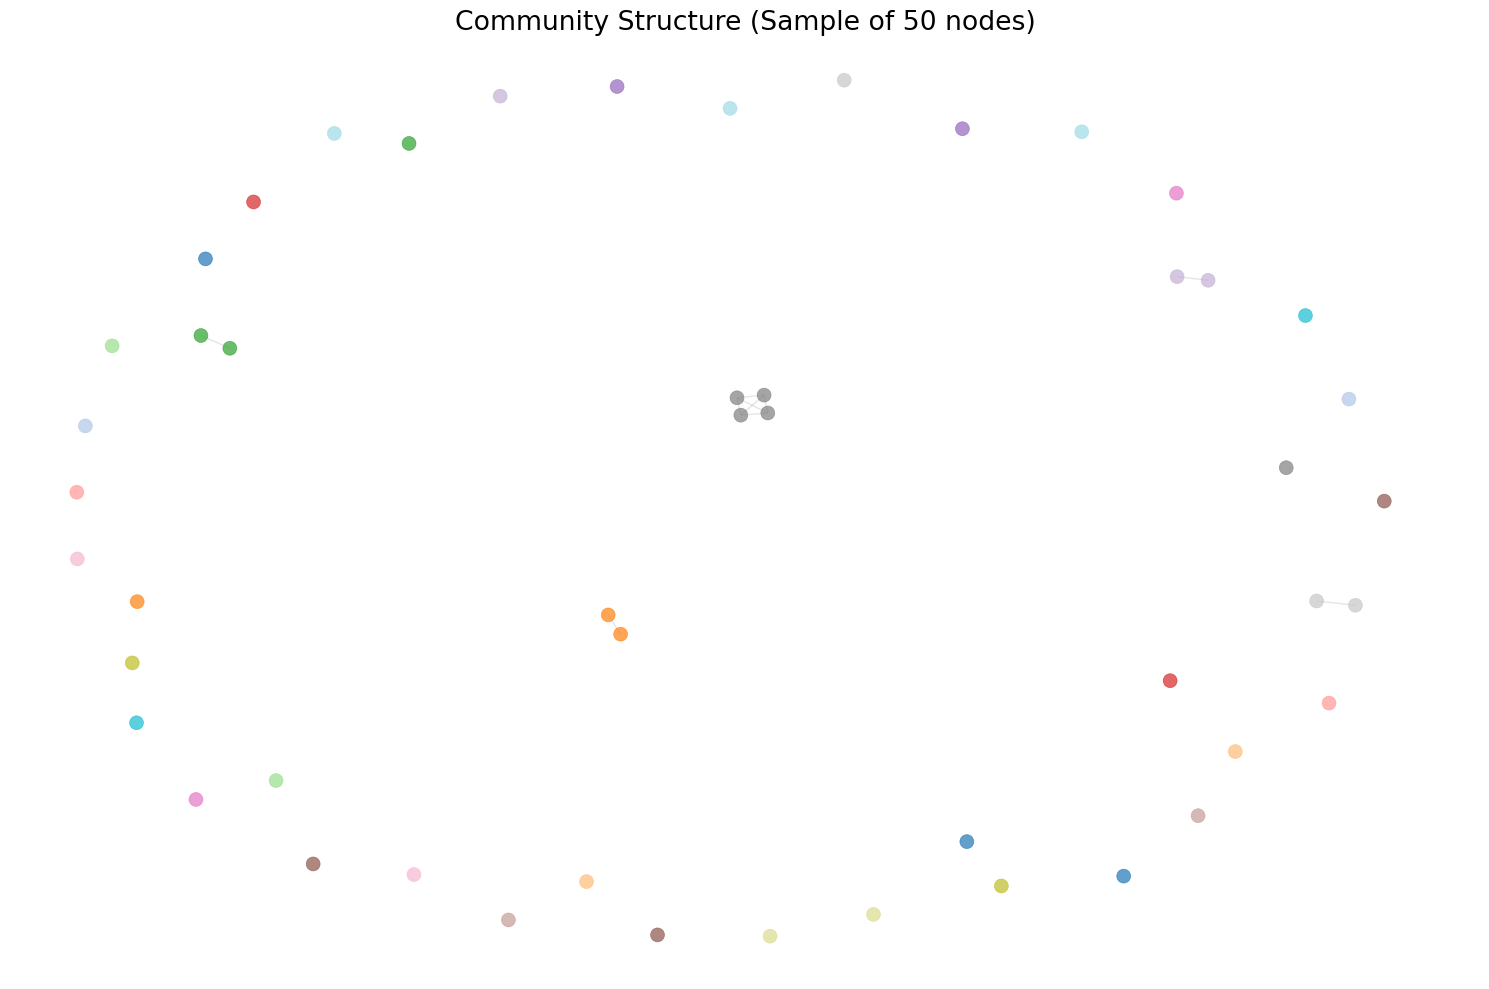

Number of communities detected: 43
Plotting company clusters...


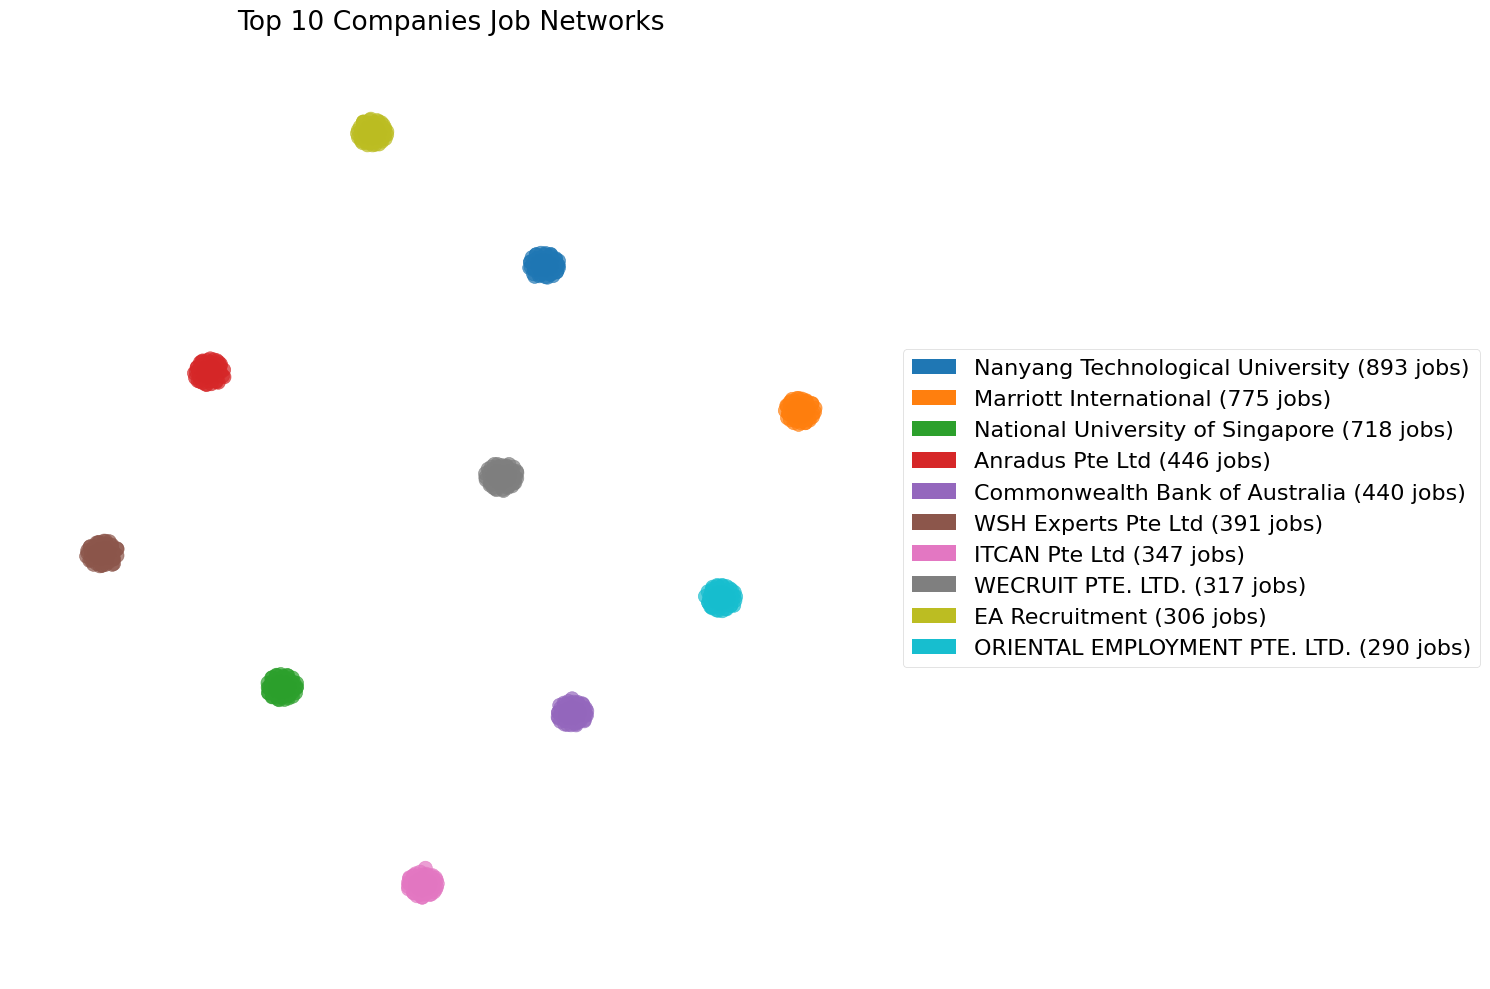

In [11]:
graph_vis = 'graph_with_company_edges.pkl'

print("Loading graph from pickle file...")
with open(graph_vis, 'rb') as f:
    graph = pickle.load(f)
    
print_graph_stats(graph)

# Generate all visualizations
visualize_graph_insights(graph, max_nodes=50)

Loading graph from pickle file...

Graph Statistics:
Number of nodes: 25,142
Number of edges: 1,816,015
Average degree: 144.46
Density: 0.005746
Min degree: 0
Max degree: 2330
Median degree: 14.0
Number of connected components: 4834
Largest component size: 15,137 nodes
Plotting high-degree nodes subset...


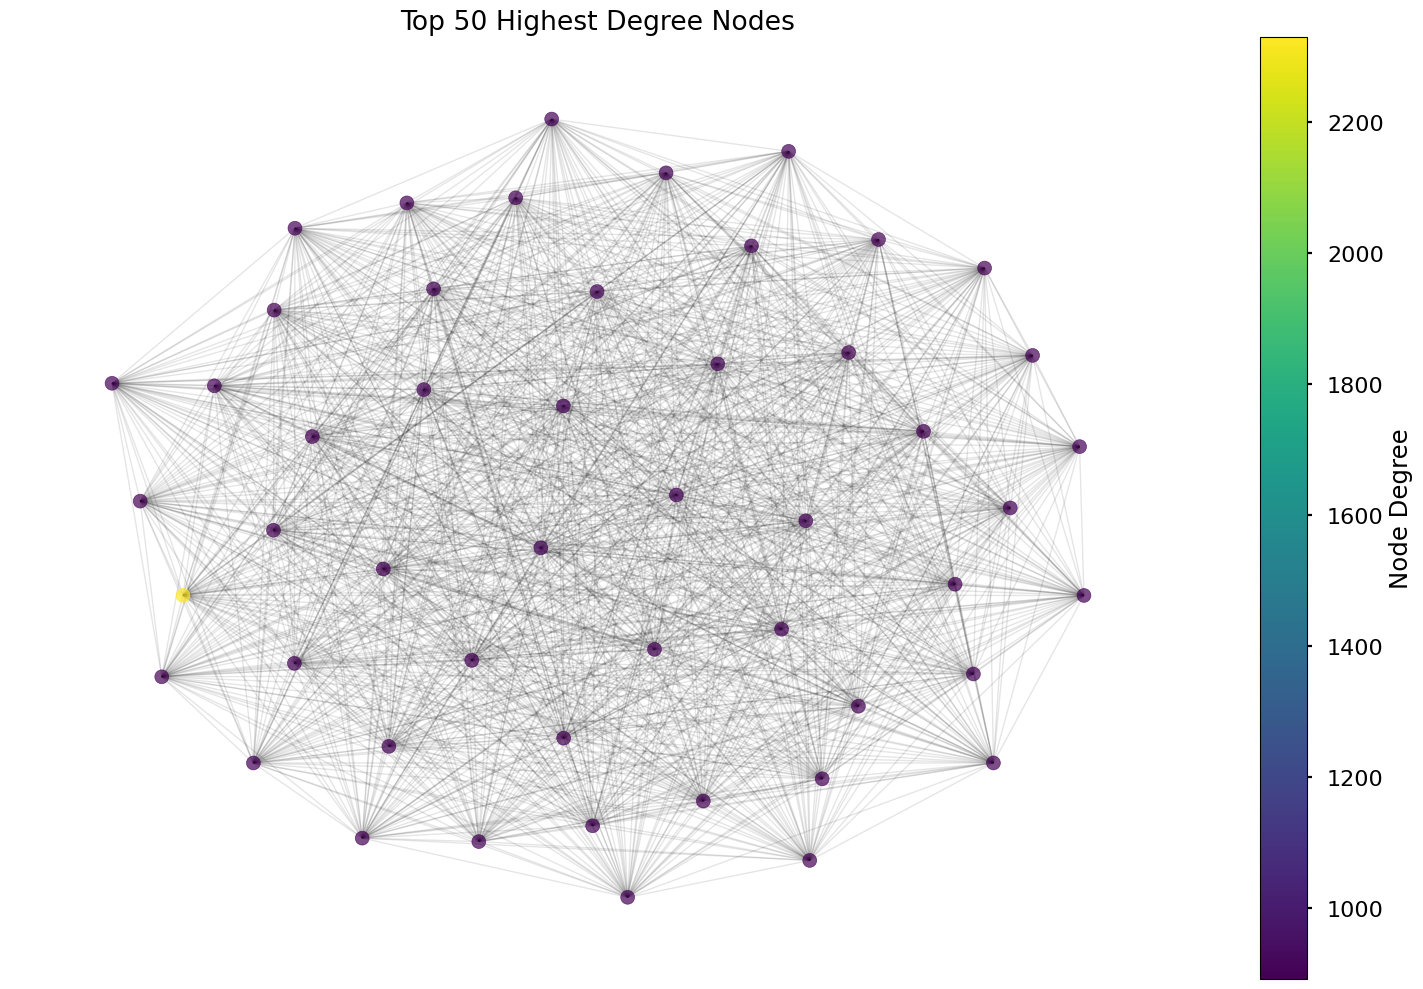

Plotting community detection visualization...


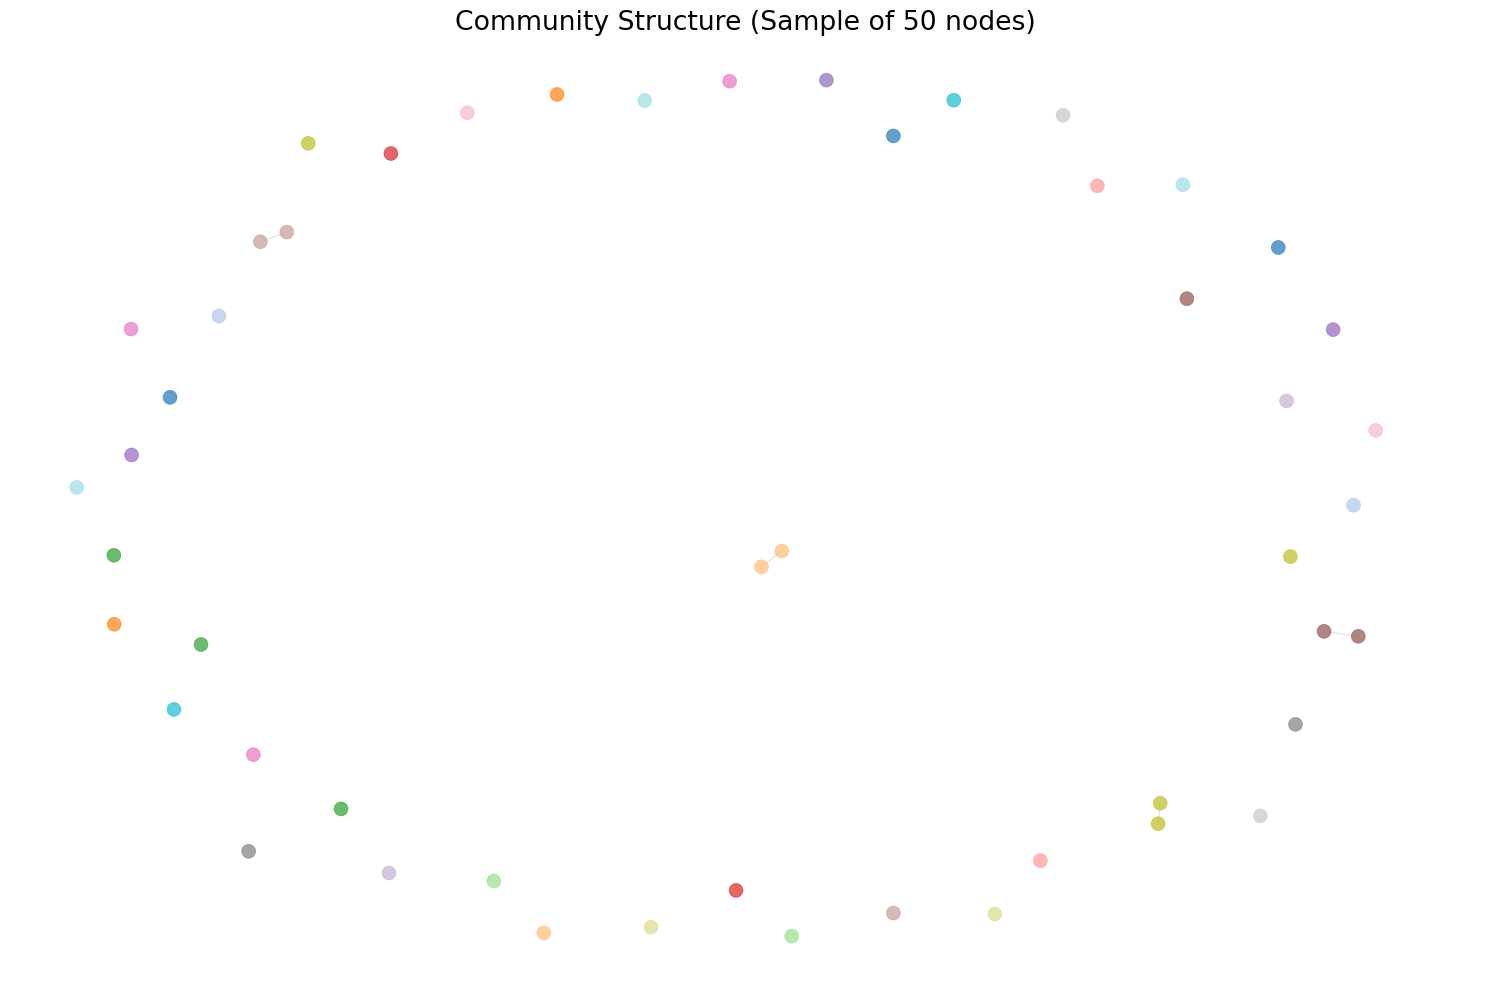

Number of communities detected: 46
Plotting company clusters...


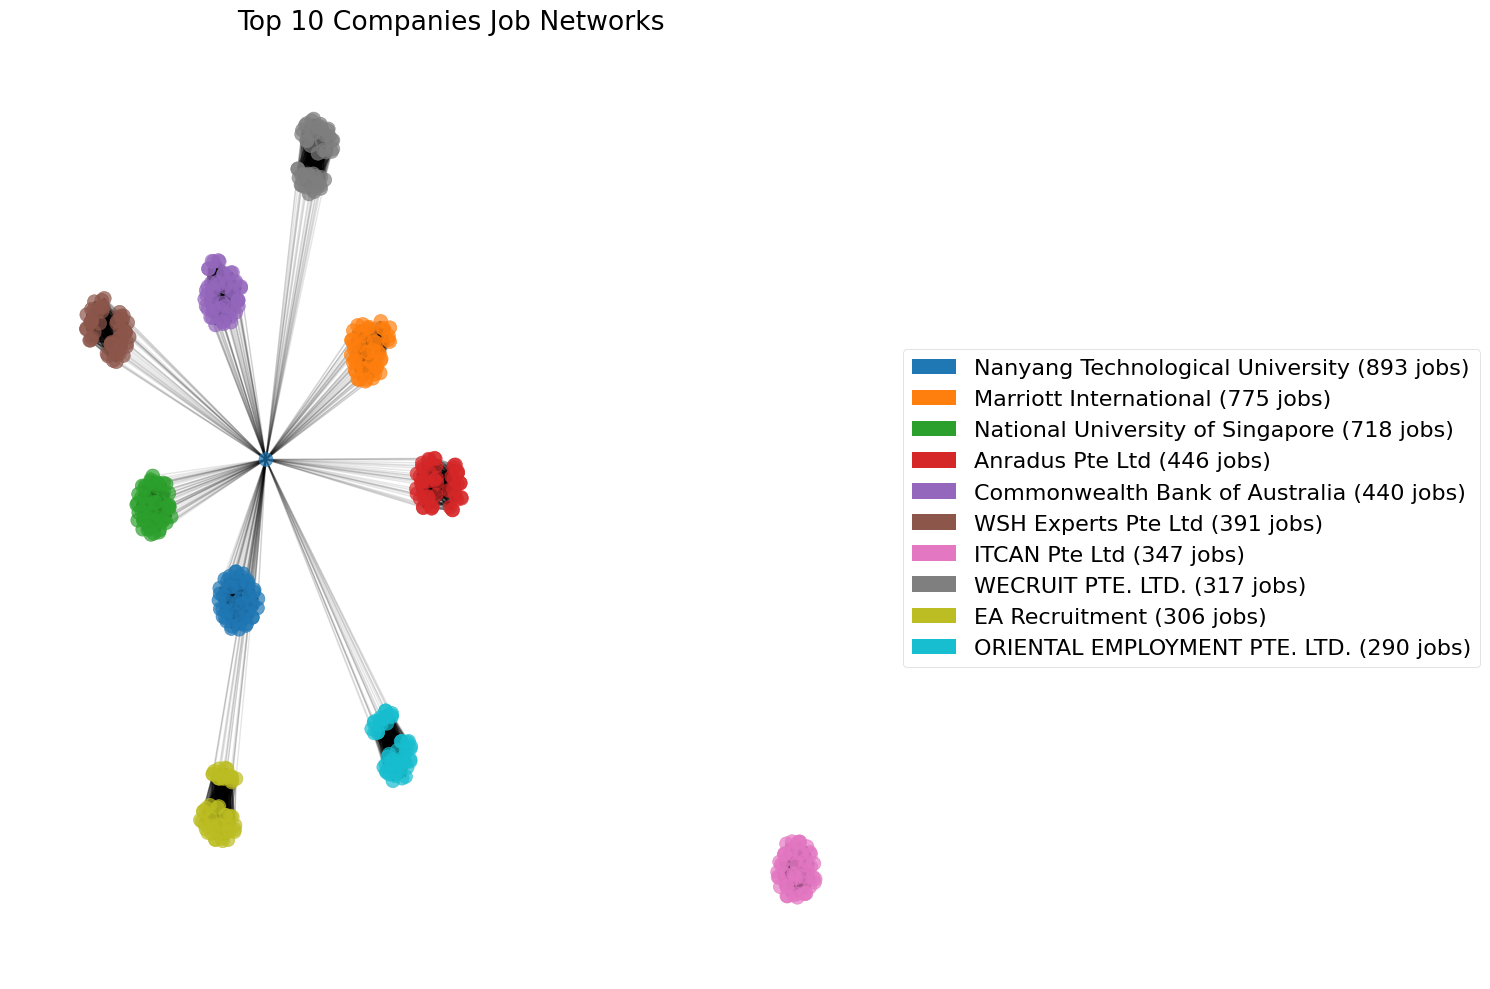

In [12]:
graph_vis = 'graph_with_job_type_edges.pkl'

print("Loading graph from pickle file...")
with open(graph_vis, 'rb') as f:
    graph = pickle.load(f)
    
print_graph_stats(graph)

# Generate all visualizations
visualize_graph_insights(graph, max_nodes=50)

In [13]:
graph_vis = 'final_complete_graph.pkl'

print("Loading graph from pickle file...")
with open(graph_vis, 'rb') as f:
    graph = pickle.load(f)
    


Loading graph from pickle file...



Graph Statistics:
Number of nodes: 25,142
Number of edges: 79,444,658
Average degree: 6319.68
Density: 0.251369
Min degree: 0
Max degree: 12689
Median degree: 2741.0
Number of connected components: 4
Largest component size: 25,139 nodes
Plotting high-degree nodes subset...


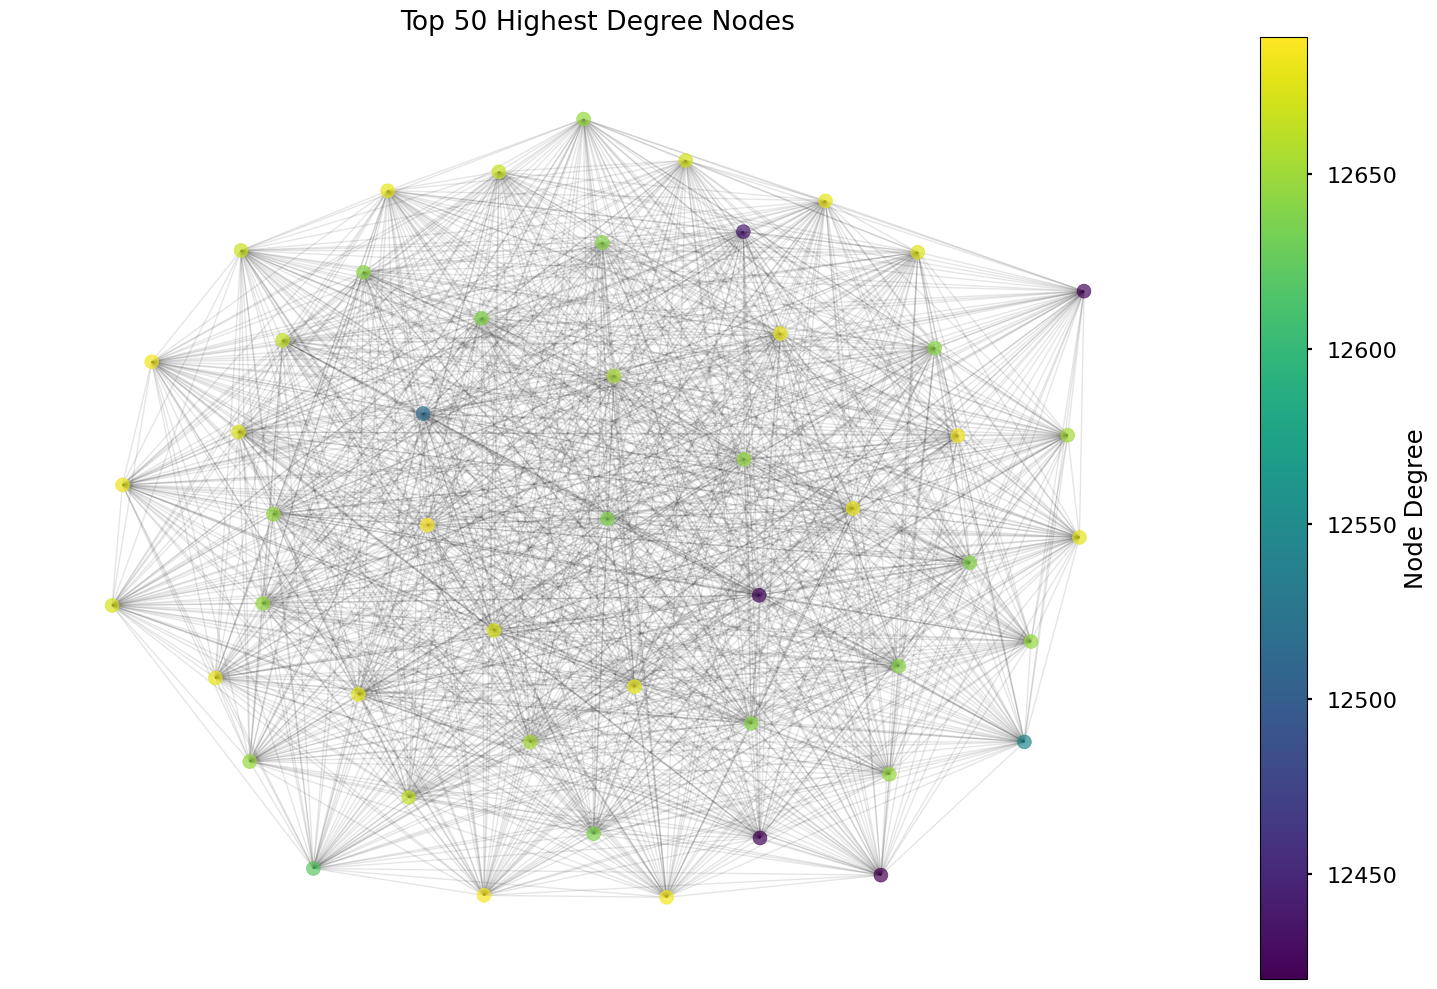

Plotting community detection visualization...


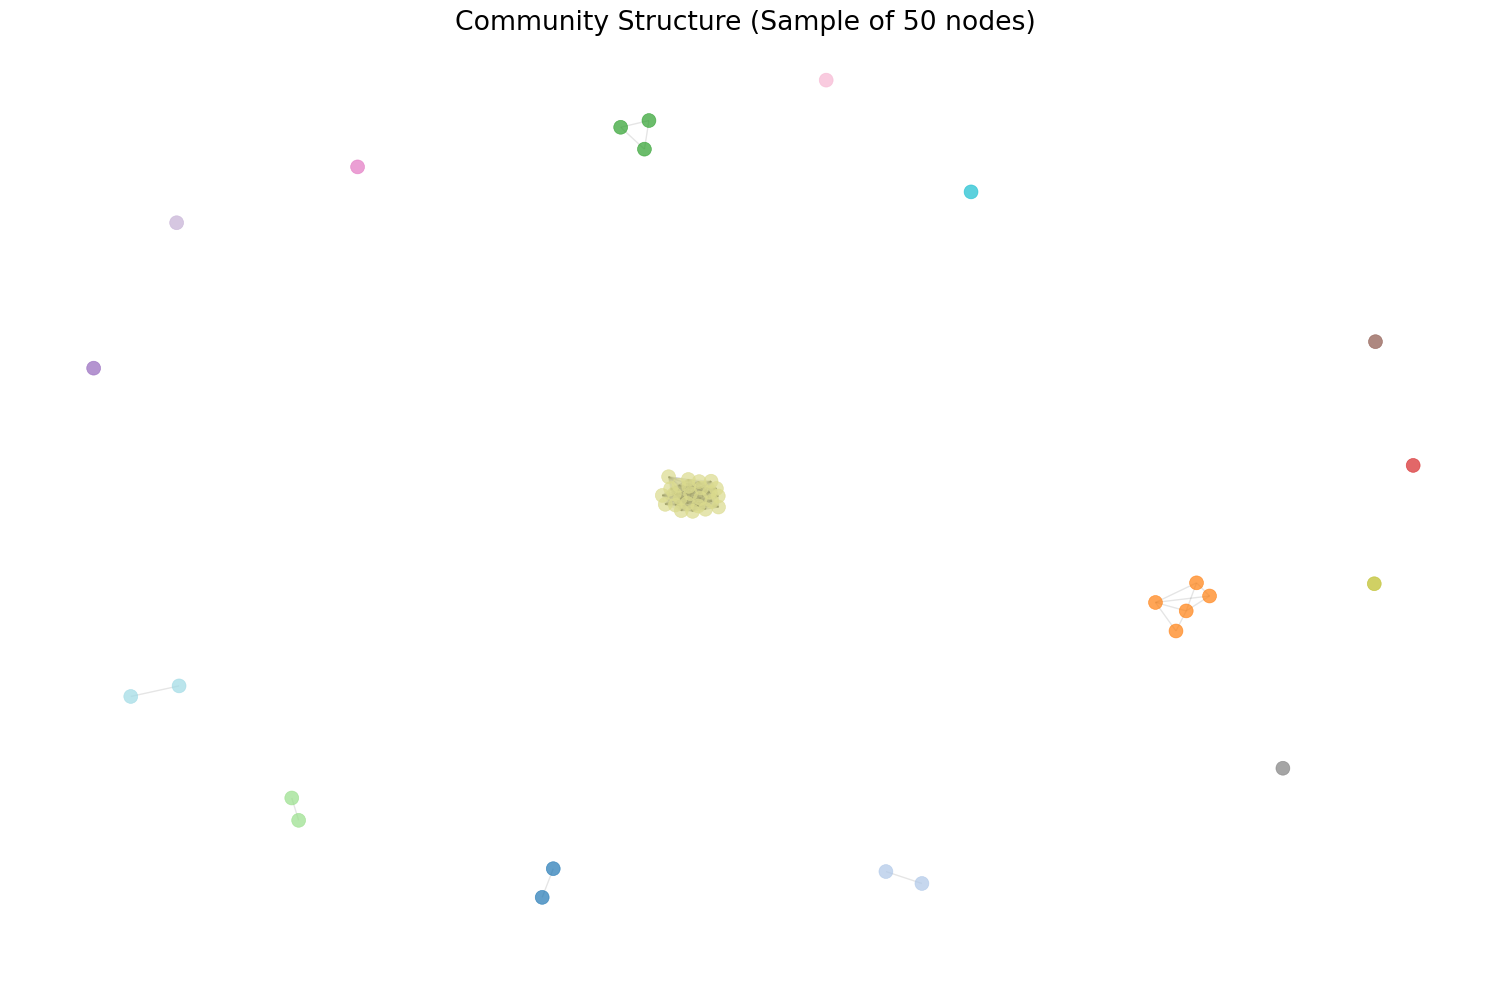

Number of communities detected: 16
Plotting company clusters...


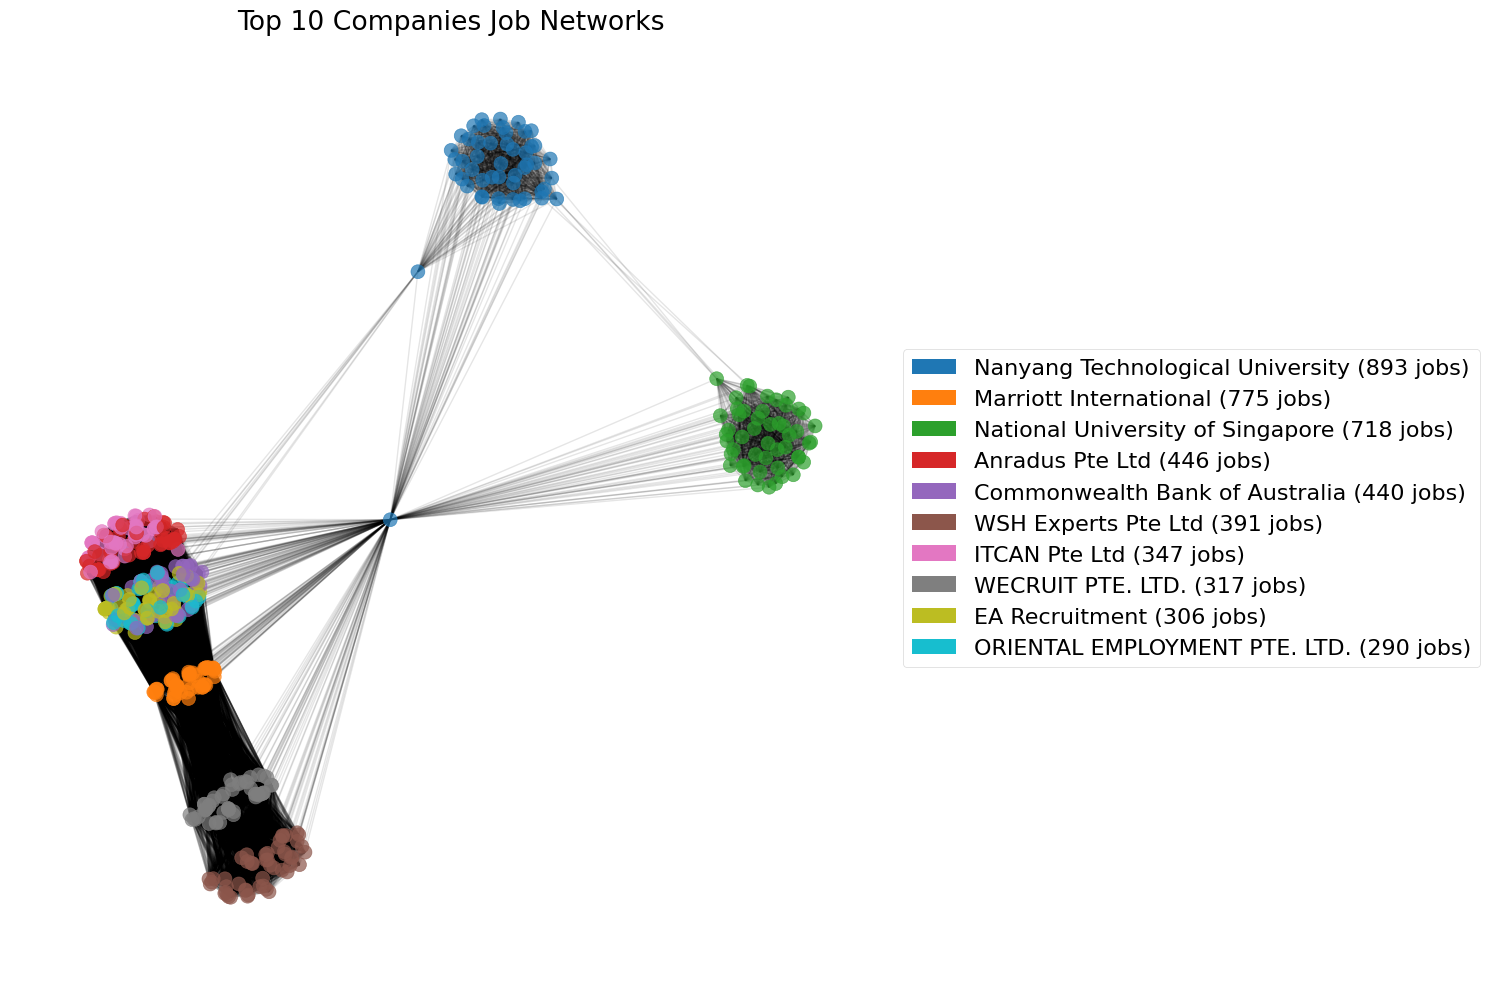

In [14]:
print_graph_stats(graph)

# Generate all visualizations
visualize_graph_insights(graph, max_nodes=50)

Plotting Singapore location heatmap...


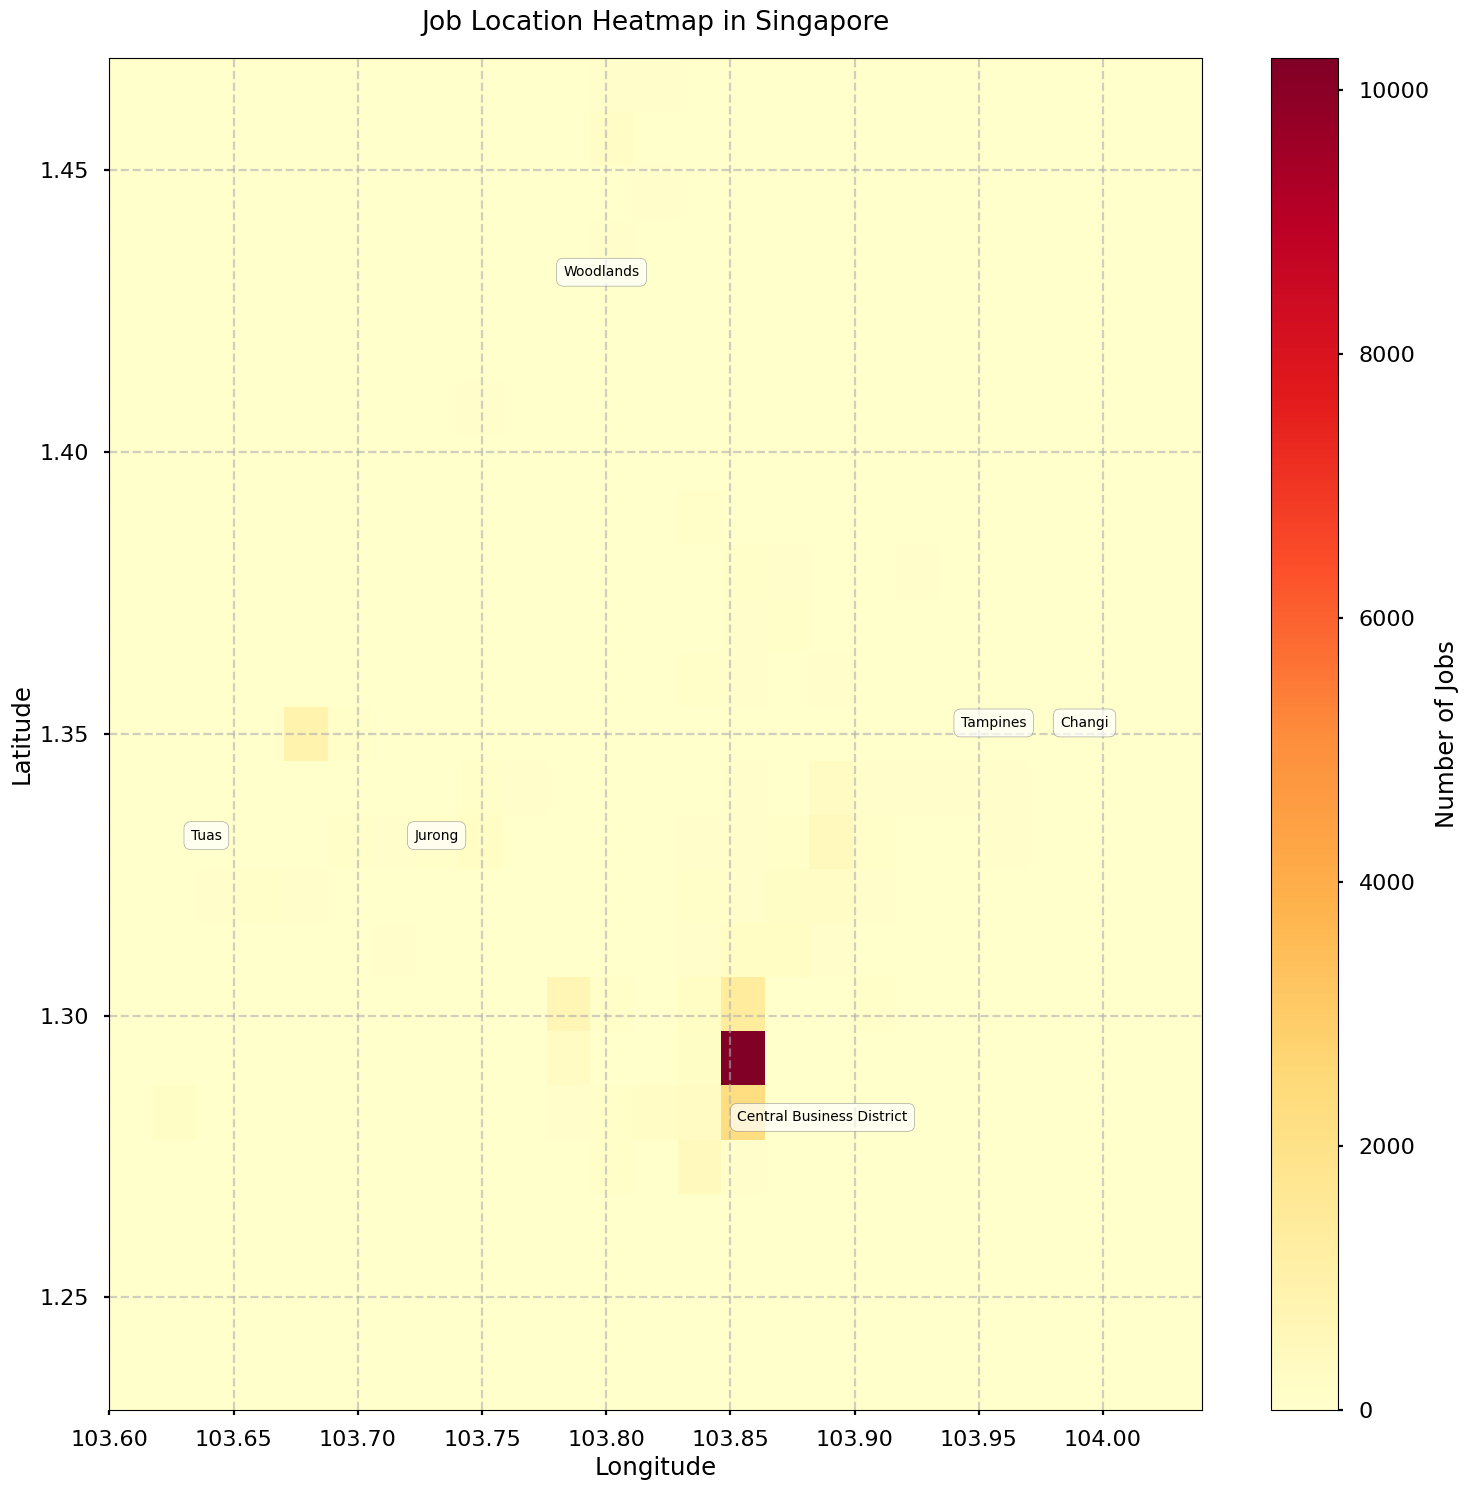


Location Statistics:
Total jobs with valid Singapore locations: 24,943

Jobs by Region (approximate):
CBD: 13,725 jobs (94.0%)
Jurong: 322 jobs (2.2%)
Tampines: 203 jobs (1.4%)
Changi: 158 jobs (1.1%)
Tuas: 114 jobs (0.8%)
Woodlands: 77 jobs (0.5%)


In [24]:
def plot_singapore_location_heatmap(graph: nx.Graph, bin_size=100):
    """
    Create a heatmap of job locations within Singapore
    
    Args:
        graph: NetworkX graph containing job data
        bin_size: Number of bins for the heatmap (higher = more detailed)
    """
    print("Plotting Singapore location heatmap...")
    
    # Singapore geographical boundaries
    SG_BOUNDS = {
        'lat_min': 1.23,    # Southern tip
        'lat_max': 1.47,    # Northern tip
        'lon_min': 103.60,  # Western edge
        'lon_max': 104.04   # Eastern edge
    }
    
    # Collect valid Singapore locations
    locations = []
    for node in graph.nodes():
        lat_long = graph.nodes[node].get('lat_long', None)
        if lat_long:
            if isinstance(lat_long, str):
                try:
                    lat_long = ast.literal_eval(lat_long)
                except:
                    continue
            
            # Check if location is within Singapore bounds
            lat, lon = lat_long
            if (SG_BOUNDS['lat_min'] <= lat <= SG_BOUNDS['lat_max'] and 
                SG_BOUNDS['lon_min'] <= lon <= SG_BOUNDS['lon_max']):
                locations.append(lat_long)
    
    if locations:
        locations = np.array(locations)
        
        # Create the main figure
        plt.figure(figsize=(15, 15))
        
        # Create heatmap
        heatmap = plt.hist2d(
            locations[:, 1],  # longitude
            locations[:, 0],  # latitude
            bins=bin_size,
            cmap='YlOrRd',
            range=[
                [SG_BOUNDS['lon_min'], SG_BOUNDS['lon_max']],
                [SG_BOUNDS['lat_min'], SG_BOUNDS['lat_max']]
            ]
        )
        
        # Add colorbar
        plt.colorbar(label='Number of Jobs')
        
        # Customize the plot
        plt.title('Job Location Heatmap in Singapore', pad=20)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        
        # Add key region annotations
        regions = {
            'CBD': (103.85, 1.28, 'Central Business District'),
            'Changi': (103.98, 1.35, 'Changi'),
            'Jurong': (103.72, 1.33, 'Jurong'),
            'Woodlands': (103.78, 1.43, 'Woodlands'),
            'Tampines': (103.94, 1.35, 'Tampines'),
            'Tuas': (103.63, 1.33, 'Tuas')
        }
        
        for _, (lon, lat, name) in regions.items():
            plt.annotate(
                name,
                xy=(lon, lat),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(
                    boxstyle='round,pad=0.5',
                    fc='white',
                    ec='gray',
                    alpha=0.7
                )
            )
        
        # Add grid for better reference
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # Tight layout to prevent label cutoff
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
        # Print statistics
        print(f"\nLocation Statistics:")
        print(f"Total jobs with valid Singapore locations: {len(locations):,}")
        
        # Calculate job density by region
        regions_count = {name: 0 for name in regions.keys()}
        region_radius = 0.02  # Approximate radius for counting nearby jobs
        
        for job_loc in locations:
            for region_name, (region_lon, region_lat, _) in regions.items():
                if (abs(job_loc[1] - region_lon) < region_radius and 
                    abs(job_loc[0] - region_lat) < region_radius):
                    regions_count[region_name] += 1
        
        print("\nJobs by Region (approximate):")
        total_jobs = sum(regions_count.values())
        for region, count in sorted(regions_count.items(), key=lambda x: x[1], reverse=True):
            if total_jobs > 0:
                percentage = (count / total_jobs) * 100
                print(f"{region}: {count:,} jobs ({percentage:.1f}%)")
            else:
                print(f"{region}: {count:,} jobs")

# Usage
plot_singapore_location_heatmap(graph, bin_size=25)

Plotting degree distribution...


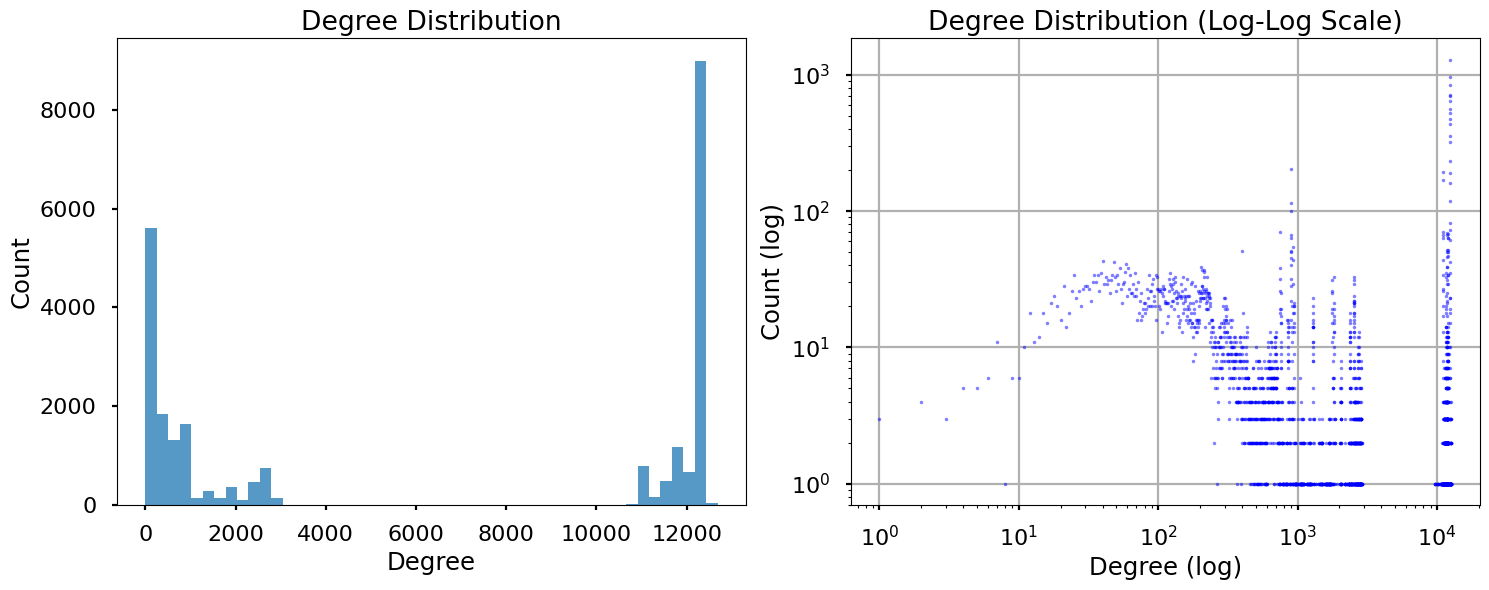

In [16]:
def plot_degree_distribution():
    """Plot the degree distribution on a log-log scale"""
    print("Plotting degree distribution...")
    degrees = [d for n, d in graph.degree()]
    degree_count = {}
    for d in degrees:
        degree_count[d] = degree_count.get(d, 0) + 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Regular scale
    ax1.hist(degrees, bins=50, alpha=0.75)
    ax1.set_title("Degree Distribution")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Count")

    # Log-log scale
    degree_sequence = sorted(degree_count.items())
    x = [k for k, v in degree_sequence]
    y = [v for k, v in degree_sequence]

    ax2.loglog(x, y, 'b.', markersize=5, alpha=0.5)
    ax2.set_title("Degree Distribution (Log-Log Scale)")
    ax2.set_xlabel("Degree (log)")
    ax2.set_ylabel("Count (log)")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_degree_distribution()

Plotting company size distribution...


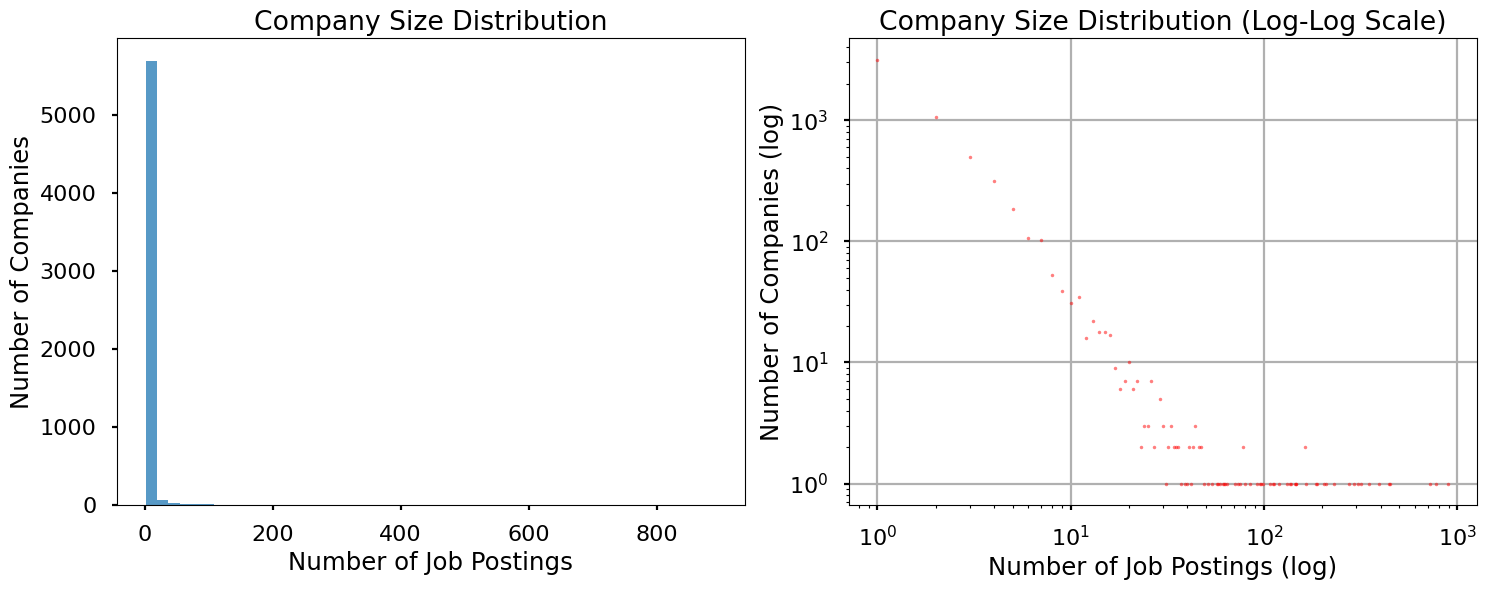


Company Size Statistics:
Total companies: 5,833
Average jobs per company: 4.3
Median jobs per company: 1.0
Max jobs per company: 893


In [20]:
def plot_company_size_distribution():
    """Plot distribution of company sizes (number of job postings)"""
    print("Plotting company size distribution...")
    company_sizes = {}
    for node in graph.nodes():
        company = graph.nodes[node].get('company', '')
        company_sizes[company] = company_sizes.get(company, 0) + 1

    sizes = list(company_sizes.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Regular scale
    ax1.hist(sizes, bins=50, alpha=0.75)
    ax1.set_title("Company Size Distribution")
    ax1.set_xlabel("Number of Job Postings")
    ax1.set_ylabel("Number of Companies")

    # Log-log scale
    size_count = {}
    for s in sizes:
        size_count[s] = size_count.get(s, 0) + 1

    size_sequence = sorted(size_count.items())
    x = [k for k, v in size_sequence]
    y = [v for k, v in size_sequence]

    ax2.loglog(x, y, 'r.', markersize=5, alpha=0.5)
    ax2.set_title("Company Size Distribution (Log-Log Scale)")
    ax2.set_xlabel("Number of Job Postings (log)")
    ax2.set_ylabel("Number of Companies (log)")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nCompany Size Statistics:")
    print(f"Total companies: {len(company_sizes):,}")
    print(f"Average jobs per company: {np.mean(sizes):.1f}")
    print(f"Median jobs per company: {np.median(sizes):.1f}")
    print(f"Max jobs per company: {max(sizes):,}")

plot_company_size_distribution()